# Phase II: Data Curation, Exploratory Analysis and Plotting
## What makes someone good at chess?

- Sandeep Salwan
- Andrew Fielding
- QuangVinh Tran

## Project Goal:

Chess is a global strategy game played by all, from children to the elderly, with countless openings, tactics, and playstyles that all influence the outcome of the match. Many dedicated chess players hone in on these aspects while reviewing past games or studying the professionals in search of improvement. However, what if the strategies employed are not the best fit for a given rank and/or playstyle? With the wealth of data available by APIs such as Lichess and Stockfish API, this project seeks to understand the effectiveness of various openings, playstyles (such as aggressive vs. passive), and common tactics at various ranks to provide users of all skill levels with applicable information to help improve their game. Additionally, with the rise of chess.com, chess can be played online with players being matched to those of similar ranking; however, not every match will be evenly set resulting in a potential skill advantage to the higher-ranked player. This study aims to explore 2 key questions:
1. Which chess openings and playstyles lead to higher win percentages across different rank levels?
2. How does the rating differential impact the outcome of a match?

#scraping data 


## Pipeline Overview:

**1. Data Collection** - Fetch player data from the **Lichess API**: usernames, game details, ratings, moves, and openings.

**2. Data Processing** - Clean up the raw data: extract openings, check game outcomes, calculate rating differences, and handle missing info.

**3. Data Analysis** - Look at win rates: figure out which **openings** and **playstyles** work best at different ranks, and how **rating gaps** affect match results.

**4. Data Export** - Save the cleaned data into a **CSV** for easy analysis and reporting.


### Pipeline:

#### 0. Imports

In [ ]:
# Install required libraries
%pip install berserk pandas chess stockfish matplotlib seaborn

In [2]:
import berserk
import pandas as pd
import chess
import chess.polyglot
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
token = "" 
session = berserk.TokenSession(token)
client = berserk.Client(session=session)


In [ ]:
# ---------------------------
# Step 1: Set Token
# ---------------------------

token = ""  # Your token

if not token:
    raise ValueError("No token.")


#### 2. Query generation API Code

In [ ]:
# ---------------------------
# Step 2: Init Client
# ---------------------------

session = berserk.TokenSession(token)
client = berserk.Client(session=session)


In [ ]:
# ---------------------------
# Step 3: Fetch Players
# ---------------------------

def get_top_players(perf='blitz', cnt=100):
    try:
        lb = client.users.get_leaderboard(perf_type=perf, count=cnt)  # leaderboard
        return [user['username'] for user in lb]  # names
    except berserk.exceptions.ResponseError as e:
        print(f"Error: {e}")
        return []  # return empty if error

# perf types to fetch
perf_types = {'blitz': 100, 'bullet': 100, 'rapid': 100, 'classical': 100}

# collect all usernames
all_users = set()
for perf, cnt in perf_types.items():
    users = get_top_players(perf, cnt)
    all_users.update(users)
    print(f"Fetched {len(users)} {perf}")

print(f"Total: {len(all_users)} users")


In [ ]:
# ---------------------------
# Step 4: Helper Functions
# ---------------------------

# retry fetching games
def get_games(username, max_games, retries=3, delay=5):
    for attempt in range(retries):
        try:
            games = client.games.export_by_player(
                username,
                max=max_games,
                perf_type='classical',  # Ensure 'classical' is correctly specified
                moves=True,
                pgn_in_json=False,
                clocks=False,
                evals=False,
                opening=True,
                as_pgn=False
            )
            return list(games)  # success
        except berserk.exceptions.ResponseError as e:
            if e.status_code == 429:  # limit hit
                print(f"Wait {delay} sec...")
                time.sleep(delay)
            else:
                print(f"Error: {e}. Retry {attempt + 1}")
                time.sleep(delay)
        except Exception as e:
            print(f"Error: {e}. Retry {attempt + 1}")
            time.sleep(delay)
    return []  # fail

# determine opening
def get_opening(moves):
    board = chess.Board()
    opening_name = 'Unknown'
    eco_code = 'Unknown'

    for move_uci in moves.split()[:20]:  # Limit to first 20 moves
        try:
            move = chess.Move.from_uci(move_uci)
            if move not in board.legal_moves:
                break  # Illegal move
            board.push(move)
            #Using python-chess's eco database to get the opening names
            current_opening = chess.polyglot.opening_name(board)
            if current_opening != "Unknown Opening":
                opening_name = current_opening
                eco_code = 'N/A'  # if unknown we cant use eco 
                break
        except Exception as e:
            print(f"Error parsing move {move_uci}: {e}")
            break  # Invalid move

    opening = f"{eco_code}: {opening_name}"
    return opening


In [ ]:
# ---------------------------
# Step 5: Fetch & Process Games
# ---------------------------

max_games = 100
sleep_time = 1  # seconds to wait

all_data = []  # store game data
print("Fetching games...")

for idx, user in enumerate(all_users):
    print(f"User {idx + 1}: {user}")
    games = get_games(user, max_games)
    print(f"Got {len(games)} games.")

    for game in games:
        try:
            white = game['players']['white'].get('user', {}).get('name', 'Anon')
            white_rating = game['players']['white'].get('rating')
            black = game['players']['black'].get('user', {}).get('name', 'Anon')
            black_rating = game['players']['black'].get('rating')

            game_id = game['id']
            link = f"https://lichess.org/{game_id}"

            opening = game.get('opening', {}).get('name', 'Unknown')
            moves = game.get('moves', '')
            if opening == 'Unknown':
                opening = get_opening(moves)

            winner = game.get('winner', 'draw')
            move_count = len(moves.split())

            all_data.append({
                'game_id': game_id,
                'white': white,
                'white_rating': white_rating,
                'black': black,
                'black_rating': black_rating,
                'opening': opening,
                'winner': winner,
                'moves': move_count,
                'link': link
            })
        except Exception as e:
            print(f"Error in {game.get('id', 'Unknown')}: {e}")

    time.sleep(sleep_time)  # respect limits

print(f"Total games: {len(all_data)}")


In [ ]:
# ---------------------------
# Step 6: Create DataFrame
# ---------------------------
#after creating the DataFrame, drop games with unknown openings
df_cleaned = df[df['opening'] != 'Unknown: Unknown']
print(f"Dropped {df.shape[0] - df_cleaned.shape[0]} games with unknown openings.")
df_cleaned.to_csv('lichess_games_data.csv', index=False)
print("Exported cleaned data to CSV.")

df = pd.DataFrame(all_data)
print(df.head())  # show first rows


In [ ]:
# ---------------------------
# Step 7: Export CSV
# ---------------------------

df.to_csv('lichess_games_data.csv', index=False)
print("Exported to CSV.")


## Visualizations:

## Analysis/ML Plan:

The data visualization shows bias for Walmart-sponsored items in their search webpage, showing the sponsored items before the non-sponsored and place them in the beginning of each pages, placing non-sponsored items of similiar prices in later pages. This is a martketing stragety from Walmart to push the customers to buy more from their brand, however, the data showed that Walmart-sponsored products are more highly rated by customers. More analysis on the quality of the products could be done over further examination of customers' ratings.

As for the ML Plan, we plan to use logarithmic regression as a binary classifier to be able to isolate each feature and study the magnitudes of each feature to analyse it effectively.

## Visualizations:

## Analysis/ML Plan:

Polynomial linear regression

In [3]:
df = pd.read_csv("/Users/andrewfielding/Desktop/DS3000/DsProject/lichess_games_data.csv")
df.head(5)

,game_id,white_player,white_rating,black_player,black_rating,opening,winner,move_count,link
0,vFnweJqm,pavaobjazevic,2286.0,Ali_Oezcelik,2006.0,A13: English Opening: Agincourt Defense,white,133,https://lichess.org/vFnweJqm
1,Jo94KKT6,Sonia111,1954.0,pavaobjazevic,2284.0,A05: Zukertort Opening: Nimzo-Larsen Variation,black,102,https://lichess.org/Jo94KKT6
2,SMfjdjMS,pavaobjazevic,2287.0,sandeepsmit11,2020.0,D35: Queen's Gambit Declined: Exchange Variati...,black,66,https://lichess.org/SMfjdjMS
3,tE7AS6Yr,superhero_13,1898.0,pavaobjazevic,2286.0,"C54: Italian Game: Classical Variation, Greco ...",black,28,https://lichess.org/tE7AS6Yr
4,mJVHivZ5,pavaobjazevic,2295.0,PinkSuccession,1898.0,A20: English Opening: King's English Variation,black,52,https://lichess.org/mJVHivZ5


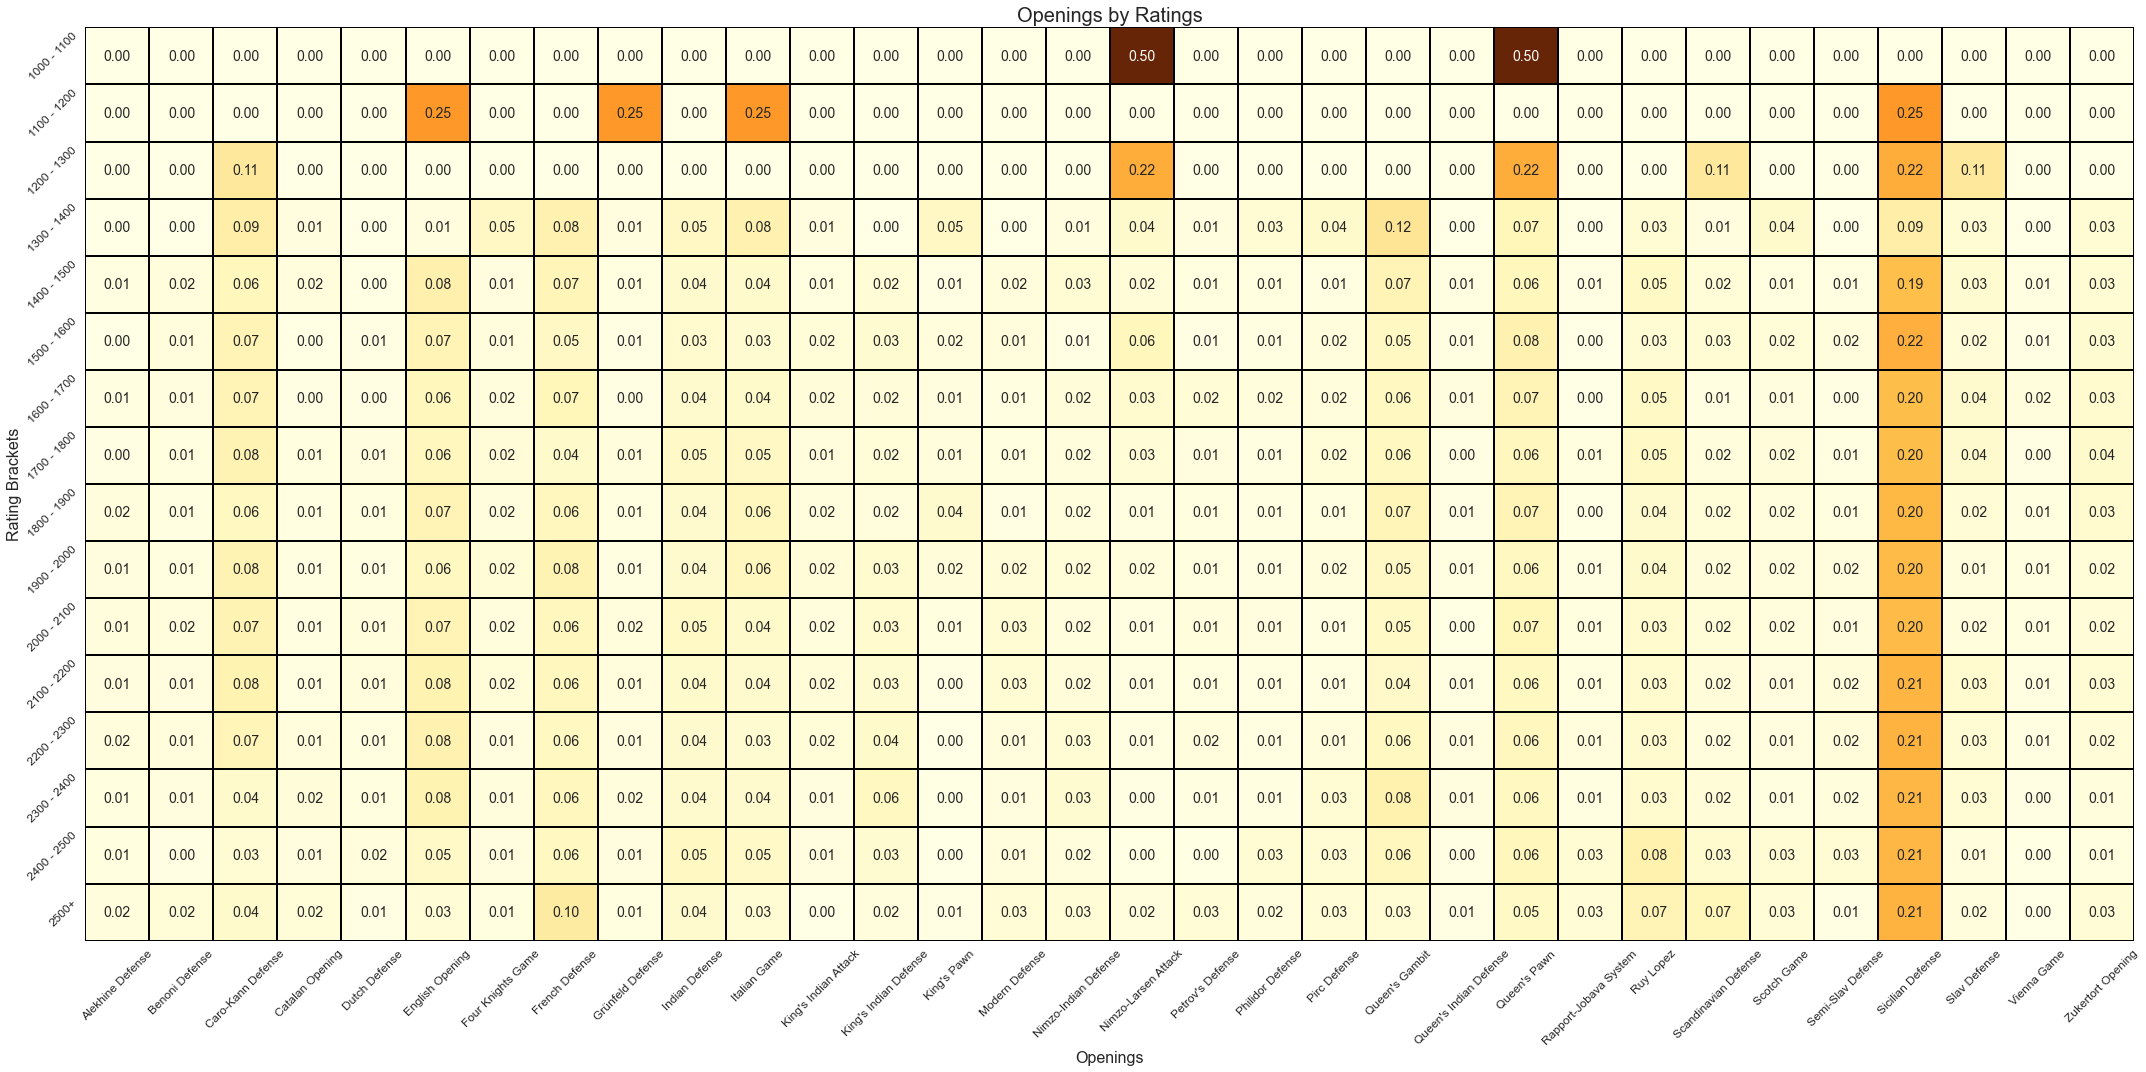

In [13]:
"""
We dont want to analyze every opening so this makes a new df that takes in
openings greater than 100 games. 
"""
# categorize ratings into buckets
def categorize_rating(rating):
    lower, upper, step = 900, 2600, 100
    while lower < upper:
        if rating <= lower:
            return f"{lower-step} - {lower}"
        lower += step
    return f"{upper-step}+"

df['rating_cat'] = df['avg_rating'].apply(categorize_rating)

# clean openings
def clean_opening(name):
    for d in [":", " |", " #", " Accepted", " Declined", " Refused"]:
        name = name.split(d)[0]
    return name

df['clean_opening'] = df['opening_name'].apply(clean_opening)

# replace specific names
df['clean_opening'].replace({
    "King's Pawn Game": "King's Pawn",
    "Queen's Pawn Game": "Queen's Pawn",
    "Ware Defense": "Ware Opening"
}, inplace=True)

# filter less than 100 games 
filtered_df = df.groupby("clean_opening").filter(lambda g: len(g) >= 100)

# pivot table creation
pivot = filtered_df.groupby(["rating_cat", "clean_opening"]).size().unstack().fillna(0)

if pivot.empty:
    print("No datainfo")
else:
    # heatmap plot
    plt.figure(figsize=(30, 15))
    sns.heatmap(
        pivot.apply(lambda row: row / row.sum() if row.sum() != 0 else row, axis=1),
        cmap='YlOrBr', annot=True, linewidths=0.005, linecolor='black',
        annot_kws={"fontsize": 14}, fmt='.2f', cbar=False
    )

    plt.title('Openings by Ratings', fontsize=20)
    plt.xlabel("Openings", fontsize=16)
    plt.ylabel("Rating Brackets", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=45)
    plt.tight_layout()
    plt.show()


1. Visualization of win percentages based on openings used, subplot based on rating categories (eg how well does each opening work for players in different categories of skill level) (bar plot) Andrew

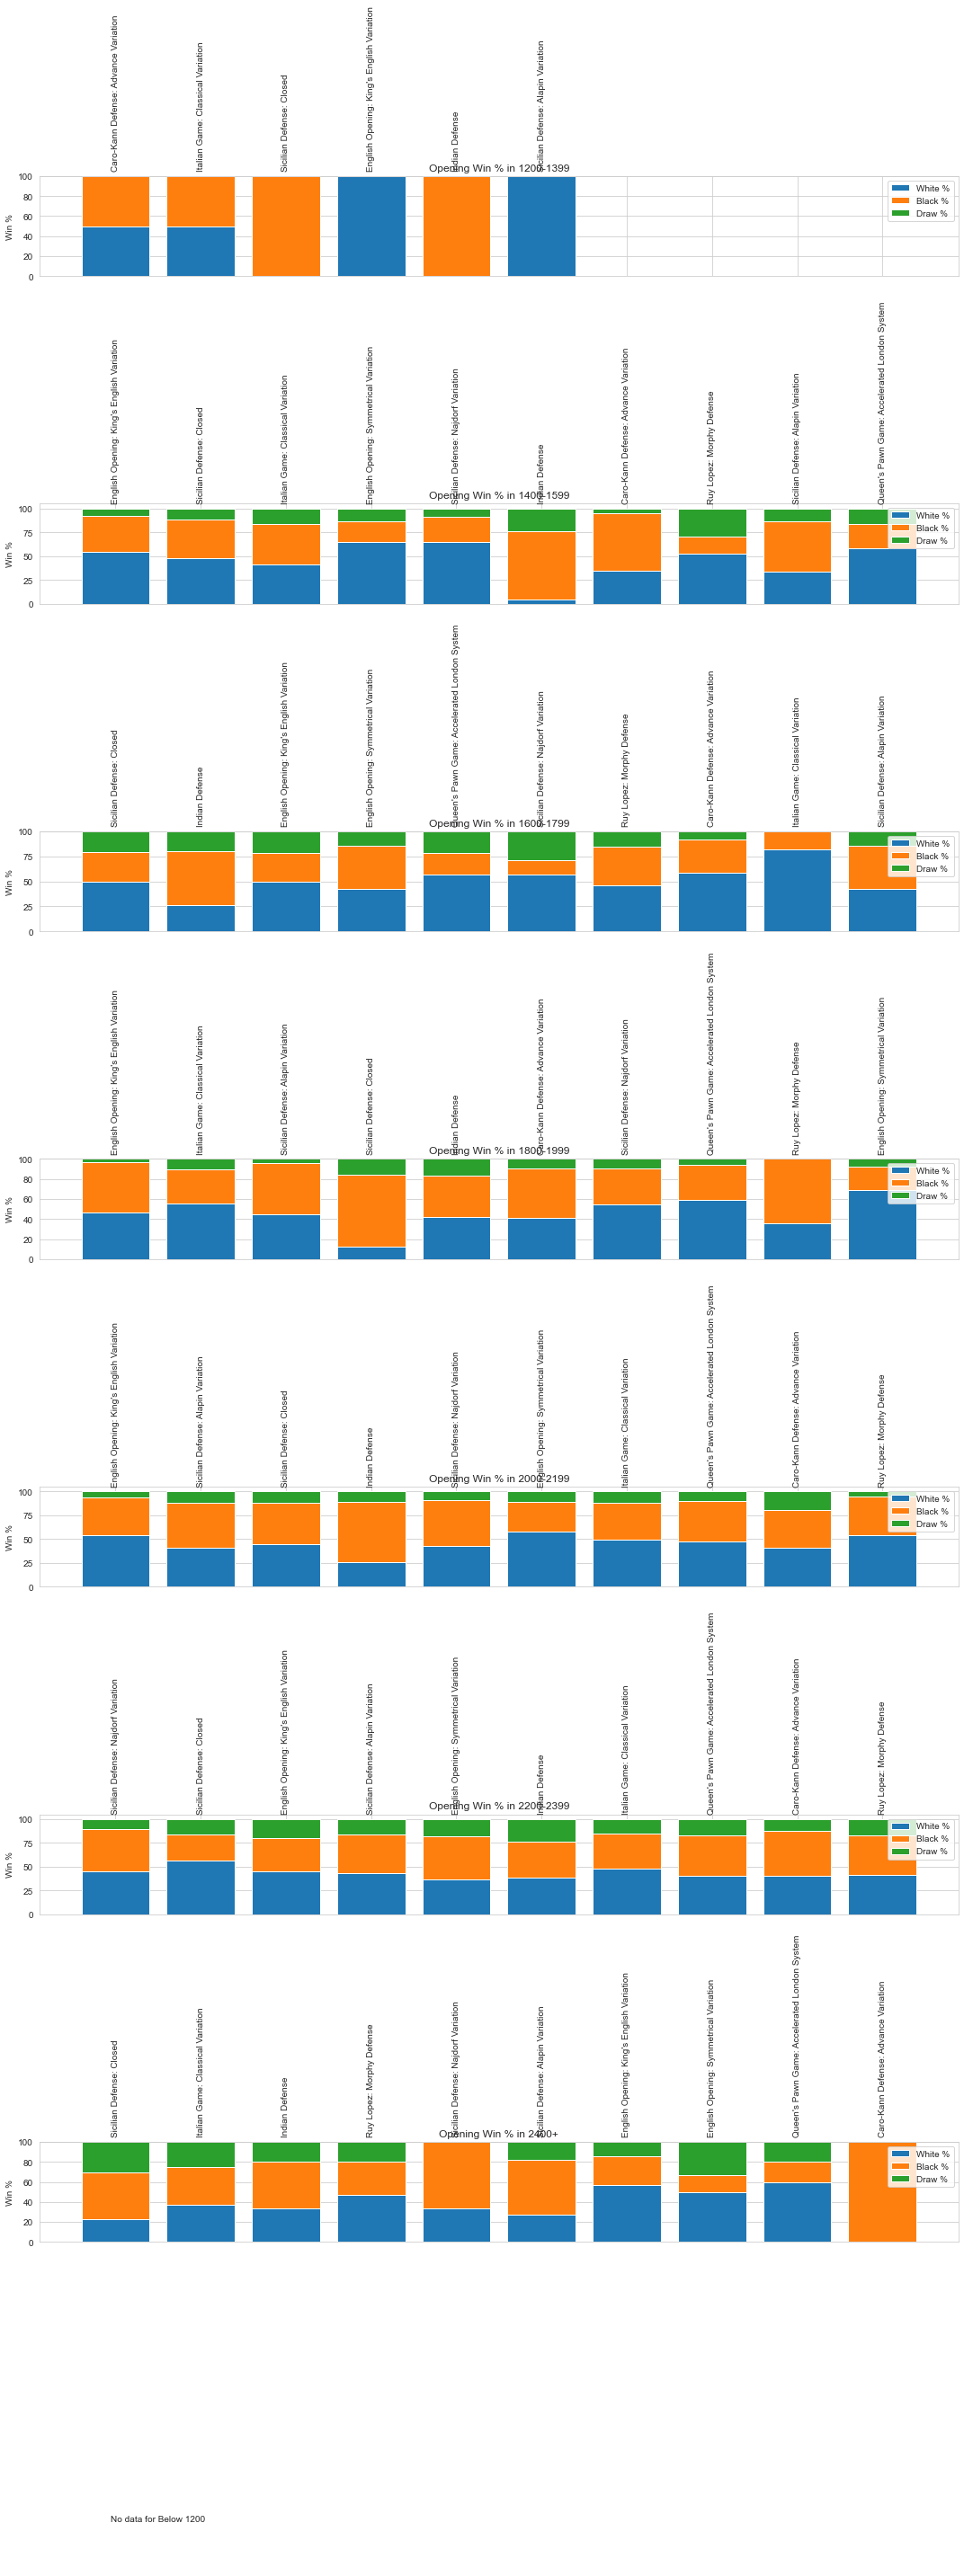

In [24]:
"""
made example graph, doesnt quite get the opening names and everything
but just showed how to use some data. 
"""

# avg rating per game
df['avg_rating'] = (df['white_rating'] + df['black_rating']) / 2

# rating categories
def rate_cat(rate):
    if rate < 1200: return 'Below 1200'
    elif rate < 1400: return '1200-1399'
    elif rate < 1600: return '1400-1599'
    elif rate < 1800: return '1600-1799'
    elif rate < 2000: return '1800-1999'
    elif rate < 2200: return '2000-2199'
    elif rate < 2400: return '2200-2399'
    else: return '2400+'

# apply rating category
df['rating_cat'] = df['avg_rating'].apply(rate_cat)
df['opening_name'] = df['opening'].str.extract(r':\s*(.*)')[0]
df['opening_name'] = df['opening_name'].str.split(',').str[0].str.strip()


# df['opening_name'].fillna('Unknown', inplace=True)
df.loc[df['opening_name'].isna(), 'opening_name'] = 'Unknown'  #or error

# top 10 openings
top_openings = df['opening_name'].value_counts().nlargest(10).index


df_top_openings = df[df['opening_name'].isin(top_openings)]

# group by rating, opening, winner
grouped = df_top_openings.groupby(['rating_cat', 'opening_name', 'winner']).size().reset_index(name='count')

# pivot table for winners
pivot_df = grouped.pivot_table(index=['rating_cat', 'opening_name'], columns='winner', values='count', fill_value=0)

# win percentages
pivot_df['total_games'] = pivot_df.sum(axis=1)
pivot_df['white_win_pct'] = (pivot_df.get('white', 0) / pivot_df['total_games']) * 100
pivot_df['black_win_pct'] = (pivot_df.get('black', 0) / pivot_df['total_games']) * 100
pivot_df['draw_pct'] = (pivot_df.get('draw', 0) / pivot_df['total_games']) * 100

# reset index for plotting
pivot_df = pivot_df.reset_index()


#demo graph 

# setup plot
sns.set_style('whitegrid')

# rating categories
rating_cats = sorted(df['rating_cat'].unique())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
#shorthandsubplot
fig, axes = plt.subplots(len(rating_cats), 1, figsize=(15, 5 * len(rating_cats)), sharex=True)

if len(rating_cats) == 1: axes = [axes]  #iterate check ifpossible

# plot by category
for idx, rcat in enumerate(rating_cats):
    ax = axes[idx]
    data = pivot_df[pivot_df['rating_cat'] == rcat].sort_values('total_games', ascending=False)
    
    if data.empty:  # check if data exists
        ax.text(0.5, 0.5, f'No data for {rcat}', ha='center', va='center')
        ax.axis('off')
        continue
    
    # stacked bars
    bar_w = 0.8
    openings = data['opening_name']
    ind = np.arange(len(openings))
    
    ax.bar(ind, data['white_win_pct'], label='White %', color=colors[0], width=bar_w)
    ax.bar(ind, data['black_win_pct'], bottom=data['white_win_pct'], label='Black %', color=colors[1], width=bar_w)
    ax.bar(ind, data['draw_pct'], bottom=data['white_win_pct'] + data['black_win_pct'], label='Draw %', color=colors[2], width=bar_w)
    
    ax.set_ylabel('Win %')
    ax.set_title(f'Opening Win % in {rcat}')
    ax.set_xticks(ind)
    ax.set_xticklabels(openings, rotation=45, ha='right')
    ax.legend(loc='upper right')
    
    # Add opening names above bars
    for i, opening in enumerate(openings):
        ax.text(i, 105, opening, ha='center', va='bottom', rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

## Andrew's attempt to clean this graph up some: ### 

In [69]:
# creates a new line character after the colon in a string, useful for splitting up the long names of openings
def new_line(item):
    split_item = item.split(':')
    if len(split_item) > 1:
        split_item.insert(1, ':\n')
    new_item = ''.join(split_item)
    
    return new_item

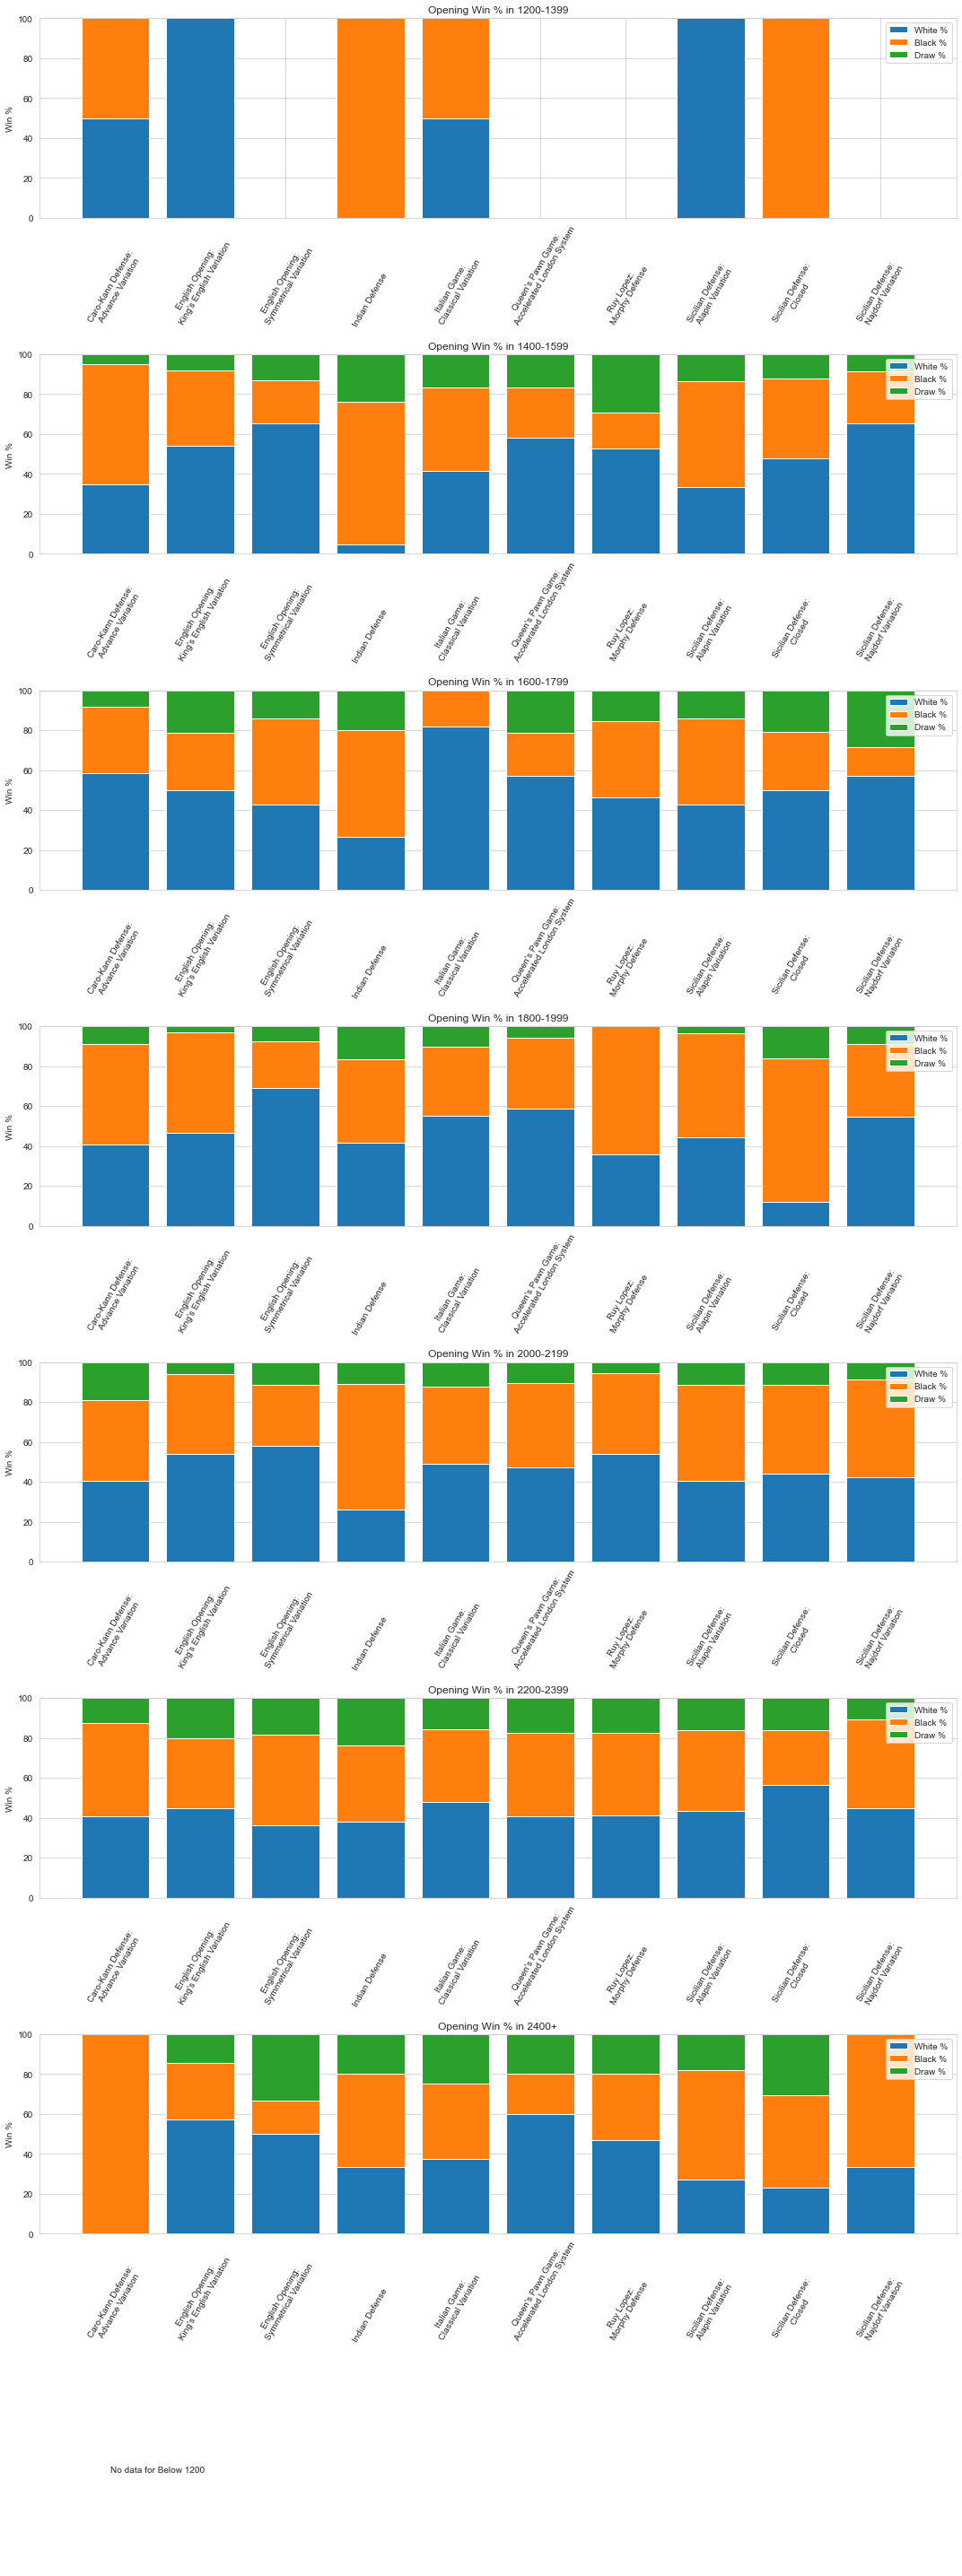

In [166]:
# groups the df by rating and orders the rows within each rating alphabetically by name of opening (for uniformity)
sorted_df_1 = pivot_df.sort_values(['rating_cat', 'opening_name'])

# setup plot
sns.set_style('whitegrid')

# rating categories
rating_cats = sorted(df['rating_cat'].unique())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
#shorthandsubplot
fig, axes = plt.subplots(len(rating_cats), 1, figsize=(15, 5 * len(rating_cats)), sharex=True)

if len(rating_cats) == 1: axes = [axes]  #iterate check ifpossible

# plot by category
for idx, rcat in enumerate(rating_cats):
    ax = axes[idx]
    data = sorted_df_1[sorted_df_1['rating_cat'] == rcat]
    
    if data.empty:  # check if data exists
        ax.text(0.5, 0.5, f'No data for {rcat}', ha='center', va='center')
        ax.axis('off')
        continue
        
    # check if the current rating category has data for all of the top openings; if not, add missing openings as empty rows
    for opening in top_openings: 
        if opening in data['opening_name'].values:
            continue
        else:
            row_dict = {'rating_cat': rcat, 'opening_name': opening, 'black': 0, 'white': 0, 'total_games': 0,
                      'white_win_pct': 0, 'black_win_pct': 0, 'draw_pct': 0}
            new_row = pd.DataFrame([row_dict])
            data = pd.concat([data, new_row], ignore_index = True)
            data = data.sort_values(['rating_cat', 'opening_name'])
            
    
    # stacked bars
    bar_w = 0.8
    openings = data['opening_name']
    openings = openings.apply(new_line)
    
    ind = np.arange(len(openings))
    
    ax.bar(ind, data['white_win_pct'], label='White %', color=colors[0], width=bar_w)
    ax.bar(ind, data['black_win_pct'], bottom=data['white_win_pct'], label='Black %', color=colors[1], width=bar_w)
    ax.bar(ind, data['draw_pct'], bottom=data['white_win_pct'] + data['black_win_pct'], label='Draw %', color=colors[2], width=bar_w)
    
    ax.set_ylabel('Win %')
    ax.set_ylim(0, 100)
    ax.set_title(f'Opening Win % in {rcat}')
    ax.set_xticks(ind)
    ax.set_xticklabels(openings, rotation=45, ha='right')
    ax.legend(loc='upper right')
    
    # Add opening names above bars
    for i, opening in enumerate(openings):
        ax.text(i, -55, opening, ha='center', va='bottom', rotation=60, fontsize=10)
        
plt.tight_layout()
plt.show()

2. Visualization of correlation between ratings (groups) and particular tactics (Bar plot) Vinh

In [ ]:
#cant do with current data

3. Aggressiveness vs rating scatterplot to see if better players tend to be more aggressive or less aggressive, potentially color by starting color to see if starting as black or white has a particular impact on aggressiveness (scatterplot) (Andrew)

In [ ]:
#cant do with current data

print(df.head())
df_top_openings = plt.xticks(fontsize = 16, rotation = 90)
plt.show()

fig, ax = plt.subplots(figsize = (24,10 ))
plt.yticks(fontsize = 16)
df5 = df5.div ( )
"birds opening".append() plt.show()

4. Histogram–frequency of victory based on rating differential to see how often a larger skill gap translates directly into a victory (Vinh)

In [116]:
# returns the loser for a given winner
def check_winner(winner):
    if winner == 'white':
        return 'black'
    elif winner == 'black':
        return 'white'
    elif winner == 'draw':
        return 'draw'
          
# creates a loser column
df['loser'] = df['winner'].apply(check_winner)

# builds an initial rating differential column
df['differential'] = df['white_rating'] - df['black_rating']

# edits values in the differential column to reflect black victories (eg flip sign of white-black base differential when black wins)
for i in range(len(df)):
    if df['winner'][i] == 'white':
        df['differential'][i] = df['differential'][i]
    elif df['winner'][i] == 'black':
        df['differential'][i] = df['differential'][i] * -1

/var/folders/6d/q5zlsgrx71g2h7_1bglpr4y40000gn/T/ipykernel_95549/3854894178.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['differential'][i] = df['differential'][i]
/var/folders/6d/q5zlsgrx71g2h7_1bglpr4y40000gn/T/ipykernel_95549/3854894178.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['differential'][i] = df['differential'][i] * -1


counts in each bin: [0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00 1.000e+00
 4.000e+00 1.100e+01 2.700e+01 2.500e+01 4.700e+01 4.700e+01 1.400e+02
 1.370e+02 1.930e+02 3.180e+02 5.650e+02 9.910e+02 2.354e+03 1.806e+03
 1.506e+03 1.166e+03 9.810e+02 7.020e+02 4.820e+02 3.920e+02 2.710e+02
 1.650e+02 1.620e+02 1.080e+02 5.900e+01 3.000e+01 2.700e+01 1.300e+01
 5.000e+00 3.000e+00 1.000e+00 2.000e+00]
bin edges: [-1800.         -1707.69230769 -1615.38461538 -1523.07692308
 -1430.76923077 -1338.46153846 -1246.15384615 -1153.84615385
 -1061.53846154  -969.23076923  -876.92307692  -784.61538462
  -692.30769231  -600.          -507.69230769  -415.38461538
  -323.07692308  -230.76923077  -138.46153846   -46.15384615
    46.15384615   138.46153846   230.76923077   323.07692308
   415.38461538   507.69230769   600.           692.30769231
   784.61538462   876.92307692   969.23076923  1061.53846154
  1153.84615385  1246.15384615  1338.46153846  1430.76923077
  1523.07692308  1615.3

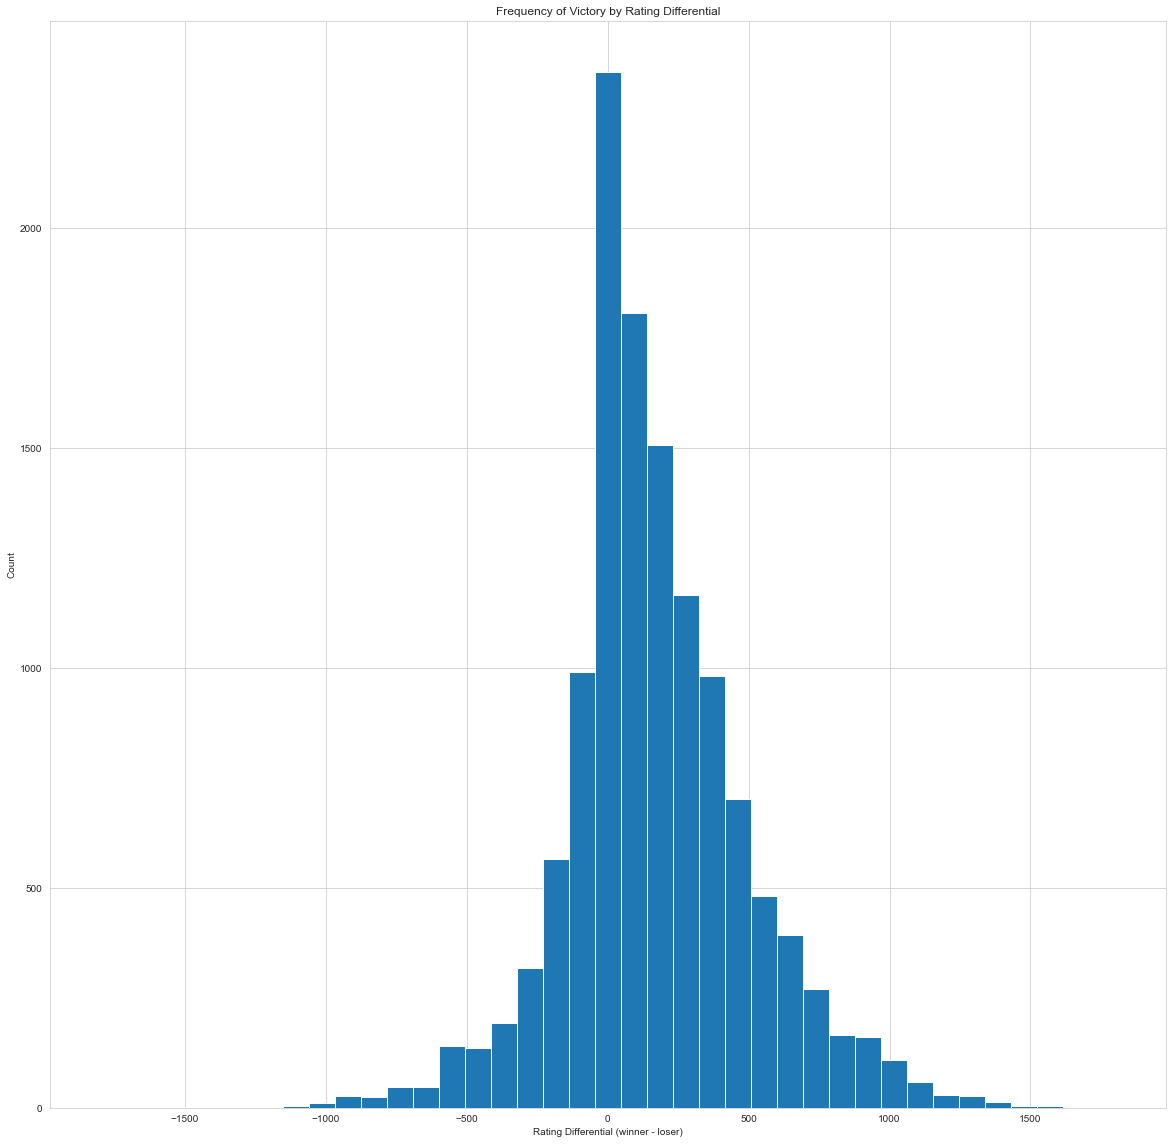

In [165]:
df_no_draw = df[df.winner != 'draw']

binss = np.linspace(-1800, 1800, 40)

counts, bins, patches = plt.hist(df_no_draw['differential'], bins = binss);
print('counts in each bin:', counts)
print('bin edges:', bins)

plt.gcf().set_size_inches(20, 20)
plt.title('Frequency of Victory by Rating Differential')
plt.xlabel('Rating Differential (winner - loser)')
plt.ylabel('Count')
plt.show()

5. How many pieces lost by move 10 style graph (Sandeep)

In [ ]:
#cant do with current dataset 